<a href="https://colab.research.google.com/github/MariaMillet/facebook-marketplaces-recommendation-ranking-system/blob/main/fb_marketplace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install libomp-dev
!pip install faiss

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp-10-dev libomp5-10
Suggested packages:
  libomp-10-doc
The following NEW packages will be installed:
  libomp-10-dev libomp-dev libomp5-10
0 upgraded, 3 newly installed, 0 to remove and 23 not upgraded.
Need to get 351 kB of archives.
After this operation, 2,281 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp5-10 amd64 1:10.0.0-4ubuntu1 [300 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp-10-dev amd64 1:10.0.0-4ubuntu1 [47.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp-dev amd64 1:10.0-50~exp1 [2,824 B]
Fetched 351 kB in 1s (528 kB/s)
Selecting previously unselected package libomp5-10:amd64.
(Reading database ... 129506 files and directories currently installed.)
Preparing to unpack .../libomp5-10_1%3a10.0.0-4ubuntu1_amd64.

In [ ]:
!pip install faiss # k-nn  to calculate semantic similarity (FACEBOOK AI SIMILARITY SEARCH)
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement faiss (from versions: none)
ERROR: No matching distribution found for faiss
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import pickle
import csv
import numpy as np
import pathlib
import os
import fnmatch
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import faiss
import copy
from torch.utils.data import random_split
from torchvision.utils import save_image, make_grid
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.nn import Conv2d, MaxPool2d

Define directories paths

In [ ]:
cleaned_images_directory_name = "/content/drive/MyDrive/facebook_ranking/cleaned_images"
project_directory = "/content/drive/MyDrive/facebook_ranking"

# Clean images


In [ ]:
ON_COLAB = False

!wget https://aicore-files.s3.amazonaws.com/images_fb.zip?download=1
# !wget https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
if ON_COLAB:
    !unzip /fb/https://aicore-files.s3.amazonaws.com/images_fb.zip?download=1
    # !unzip /content/NaturalImageNetTrain.zip?download=1 > /dev/null

--2023-01-20 11:12:08--  https://aicore-files.s3.amazonaws.com/images_fb.zip?download=1
Resolving aicore-files.s3.amazonaws.com (aicore-files.s3.amazonaws.com)... 3.5.8.210, 54.231.169.161, 52.216.154.180, ...
Connecting to aicore-files.s3.amazonaws.com (aicore-files.s3.amazonaws.com)|3.5.8.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2550752631 (2.4G) [application/zip]
Saving to: ‘images_fb.zip?download=1’

images_fb.zip?downl  32%[=====>              ] 778.54M  46.1MB/s    eta 38s    ^C


In [ ]:
!unzip images_fb.zip?download=1 > /dev/null

  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of images_fb.zip?download=1 or
        images_fb.zip?download=1.zip, and cannot find images_fb.zip?download=1.ZIP, period.

No zipfiles found.


In [ ]:
def resize_image(final_size, im):
    size = im.size
    ratio = float(final_size) / max(size)
    new_image_size = tuple([int(x*ratio) for x in size])
    im = im.resize(new_image_size, Image.ANTIALIAS)
    new_im = Image.new("RGB", (final_size, final_size))
    # pasting a downsized image inside a square image (final_size x final_size)
    # the location of pasting is a tuple (second argument) - shows a location of 
    # the upper left corner 
    new_im.paste(im, box=((final_size-new_image_size[0])//2, (final_size-new_image_size[1])//2))
    return new_im

In [ ]:
if __name__ == '__main__':
    path = "images"
    dirs = os.listdir(path)
    final_size = 512
    cleaned_images_directory_name = "/content/drive/MyDrive/facebook_ranking/cleaned_images"
    isExist = os.path.exists(cleaned_images_directory_name)
    if not isExist:
      os.mkdir(cleaned_images_directory_name)
      print("Directory " , cleaned_images_directory_name ,  " Created ") 
      for n, item in enumerate(dirs):
          print(item)
          if n % 100 == 0:
              print(n, item)
          if 'csv' in item:
              continue
          im = Image.open('images/'+item)
          #  print(item)
          new_im = resize_image(final_size, im)
          new_im.save(f'{cleaned_images_directory_name}/{os.path.basename(item)}')

FileNotFoundError: ignored

# Clean tabular data

In [ ]:
df_products = pd.read_csv(project_directory + '/Products.csv', header=0, lineterminator='\n')
print(df_products.columns)
df_products.drop(columns=['Unnamed: 0'], inplace=True)

Index(['Unnamed: 0', 'id', 'product_name', 'category', 'product_description',
       'price', 'location'],
      dtype='object')


In [ ]:
# pre-processing "price" column - removing £ sign and making numerical
df_products['price'] = df_products['price'].str.strip('£')
df_products['price'] = df_products['price'].apply(lambda x: x if ',' not in x else x.replace(',',''))

df_products['price'] = df_products['price'].astype('float64')
df_products.to_csv('Cleaned_products.csv')

In [ ]:
df_products['category'].unique()

array(['Home & Garden / Dining, Living Room Furniture / Mirrors, Clocks & Ornaments',
       'Home & Garden / Other Household Goods',
       'Home & Garden / Garden & Patio / Outdoor Settings & Furniture',
       'Home & Garden / Dining, Living Room Furniture / Other',
       'Home & Garden / Dining, Living Room Furniture / Sofas, Armchairs & Suites / Private',
       'Home & Garden / Beds & Bedroom Furniture / Wardrobes, Shelving & Storage / Private',
       'Home & Garden / Beds & Bedroom Furniture / Double Beds / Private',
       'Home & Garden / Dining, Living Room Furniture / Dining Tables & Chairs',
       'Home & Garden / Beds & Bedroom Furniture / Other Bedroom Furniture & Accs',
       'Home & Garden / Dining, Living Room Furniture / Lighting & Fittings',
       'Home & Garden / Kitchenware & Accessories / Kitchen Storage / Other Kitchen Storage',
       'Home & Garden / Kitchenware & Accessories / Tableware / Dinnerware & Crockery',
       'Home & Garden / Dining, Living Room

## Exploring the dataset

In [ ]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7156 entries, 0 to 7155
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   7156 non-null   object 
 1   product_name         7156 non-null   object 
 2   category             7156 non-null   object 
 3   product_description  7156 non-null   object 
 4   price                7156 non-null   float64
 5   location             7156 non-null   object 
dtypes: float64(1), object(5)
memory usage: 335.6+ KB


In [ ]:
df_images_ids = pd.read_csv(project_directory+'/Images.csv', header=0, lineterminator='\n')
df_images_ids.drop(columns=['Unnamed: 0'], inplace=True)
df_images_ids.info()
print(f'There are {len(df_products)} entries in products dataset and {len(df_images_ids)} entries in images_to_ids dataset')
intersection = set(df_products['id']) & set(df_images_ids['product_id'])
print(f"There are {len(intersection)} images listed in both datasets")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12604 entries, 0 to 12603
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12604 non-null  object
 1   product_id  12604 non-null  object
dtypes: object(2)
memory usage: 197.1+ KB
There are 7156 entries in products dataset and 12604 entries in images_to_ids dataset
There are 7052 images listed in both datasets


In [ ]:
df_images_ids.head()
cleaned_images_directory_name = "/content/drive/MyDrive/facebook_ranking/cleaned_images"
# %%
#Loading names of images into a list 
imgdir_path = pathlib.Path(cleaned_images_directory_name)
file_list = sorted([os.path.basename(str(path))[:-4] for path in imgdir_path.glob('*.jpg')])
print(file_list[0])

# %%
df_images_data = df_images_ids[df_images_ids['id'].isin(file_list)]

intersection = set(df_images_data['product_id']) & set(df_products['id'])
print(f"There are {len(file_list)} of images in total, \
        \nof which {len(df_images_data)} are listed in Images.csv file. \
        \n{len(intersection)} images have a corresponding entry in Image/product.csv")

# %%
file_list[:10]
# %%
combined_df = df_products.copy()
combined_df.rename(columns={'id': 'product_id'}, inplace=True)

combined_df.info()
# %%
combined_df = combined_df.merge(df_images_data, how='inner', on='product_id')
# %%
combined_df.info()
# %%
combined_df.rename(columns={'id': 'image_id'}, inplace=True)
combined_df.info()
# %%
# extracting main and subcategory
combined_df['main_category'] = combined_df['category'].apply(lambda x: x.split('/')[0].strip())
combined_df['sub_category'] = combined_df['category'].apply(lambda x: ('/').join(x.split('/')[1:]))
# %%
combined_df.head(5)
# %%
# checking labels are all unique
combined_df['main_category'].unique()
# %%
# changing 'main_category' type into a category
combined_df['main_category'] = combined_df['main_category'].astype('category')
# %%
combined_df.info()
# %%
print(combined_df['main_category'].unique().to_list())
print(len(combined_df['main_category'].unique()))
combined_df.to_csv('combined_df.csv', index=False)

00009f42-5d0e-4315-8c81-291aaf17cfad
There are 12668 of images in total,         
of which 12604 are listed in Images.csv file.         
7052 images have a corresponding entry in Image/product.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7156 entries, 0 to 7155
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           7156 non-null   object 
 1   product_name         7156 non-null   object 
 2   category             7156 non-null   object 
 3   product_description  7156 non-null   object 
 4   price                7156 non-null   float64
 5   location             7156 non-null   object 
dtypes: float64(1), object(5)
memory usage: 335.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12604 entries, 0 to 12603
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           12604 non

# Image dataset

In [ ]:
imgdir_path = pathlib.Path(cleaned_images_directory_name)
# file_list = sorted([os.path.basename(str(path))[:-4] for path in imgdir_path.glob('*.jpg')])
# print(len(file_list))
df = pd.read_csv("combined_df.csv", header=0, lineterminator='\n').sort_values(by='image_id')
# print(len(df))
# file_list = sorted([os.path.basename(str(path))[:-4] for path in imgdir_path.glob('*.jpg') if os.path.basename(str(path))[:-4] in df['image_id'].unique()])
# print(file_list)

In [ ]:
unique_file_ids = df['image_id'].unique()
file_list = sorted([os.path.basename(str(path))[:-4] for path in imgdir_path.glob('*.jpg')])
file_list = [file for file in file_list if file in unique_file_ids]

In [ ]:
print(len(file_list))

12604


### Generating random indices for Train/ Test and Validation split

In [ ]:
np.random.seed(0)
train_indices = np.random.choice(len(file_list), size=int(len(file_list)*0.7), replace=False)
valid_test_indices = set(np.arange(len(file_list))) - set(train_indices)
len(train_indices) + len(valid_test_indices)
valid_indices = np.random.choice(list(valid_test_indices), size=int(len(file_list)*0.15), replace=False)
test_indices = valid_test_indices - set(valid_indices)

## Image dataset

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize([256, 256]),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class ImageDataset(Dataset):
    def __init__(self, indices, transform=None):
        self.indices = indices
        self.file_list, self.df = self._get_file_list()
        self.transform = transform
        self._get_labels()
    

    def _get_file_list(self):
        imgdir_path = pathlib.Path(cleaned_images_directory_name)
        file_list = sorted([os.path.basename(str(path))[:-4] for path in imgdir_path.glob('*.jpg')])
        df = pd.read_csv("combined_df.csv", header=0, lineterminator='\n').sort_values(by='image_id')
        unique_file_ids = df['image_id'].unique()
        file_list = [file for i, file in enumerate(file_list) if file in unique_file_ids and i in self.indices]

        # print(df.head(2))
        # print(pd.DataFrame(file_list, columns=['image_id']).head(1))
        df = pd.DataFrame(file_list, columns=['image_id']).merge(df, how='inner', on='image_id')       
        return file_list, df

    def _get_labels(self):
        # print(sorted(list(self.df['main_category'].unique())))
        self.classes = sorted(list(self.df['main_category'].unique()))
        self.idx_to_class = {i: j for i, j in enumerate(self.classes)}
        self.class_to_idx = {value: key for key, value in self.idx_to_class.items()}
        # create a binary pickle file 
        
        f = open(project_directory + "/image_decoder.pkl","wb")
        # write the python object (dict) to pickle file
        pickle.dump(self.idx_to_class,f)
        # close file
        f.close()

    def __getitem__(self, index):
        path = os.path.join(cleaned_images_directory_name, str(self.file_list[index]) + ".jpg")
        img = Image.open(path)
        if self.transform is not None:
            img = self.transform(img)
        class_label = self.df[self.df['image_id'] == self.file_list[index]]['main_category']
        label = self.class_to_idx[class_label.item()]
        return img, label
    
    def __len__(self):
        return len(self.file_list)


train_dataset = ImageDataset(train_indices, transform_train)
valid_dataset = ImageDataset(valid_indices, transform)
test_dataset = ImageDataset(test_indices, transform)

In [ ]:
test_dataset.file_list

['00009f42-5d0e-4315-8c81-291aaf17cfad',
 '00369118-eaaf-49ee-af6f-66b557f07140',
 '004353f6-ce2d-457c-8d89-5cc14cfafe2b',
 '00906682-7dbe-4f8c-9345-dc7f91c46d9e',
 '00f49f02-3676-47c9-816b-da6b62f7235a',
 '010232ae-6556-4a49-8aaa-6e9a3d57f04f',
 '011e6de3-2d8a-4d2b-babf-0417db710be5',
 '0121ff53-523a-4e8f-a01f-bbad24f1d244',
 '0125462b-8be3-4dcb-8d0d-095719986983',
 '01561050-e51c-4498-af8f-a29d9ea33a89',
 '0156e209-944d-40f6-aab6-98c1ccb449b9',
 '016ae17b-3809-4a68-88b5-c64bfe6fb940',
 '01721f79-81de-4a78-afa4-fe72f812ce1d',
 '01774a5a-a318-49bb-9c29-4782a2a7ad62',
 '018114a5-997b-4051-beed-f6594be3527f',
 '01974279-ff8f-4dd1-b6f8-3464afa54724',
 '01c760f2-1d83-4ccf-8a77-11162a89bd72',
 '01f55f07-c2fa-4b2a-8659-aa9113704a28',
 '01f600e5-7e05-4c60-9259-1670e6b31bb4',
 '02038d35-82a7-4dfb-8c46-70d8ebf3dafa',
 '023b1f3a-f06a-49fc-b3cc-9a98314dec5a',
 '0252ecbf-0c75-4cb4-b18d-b6104266e66e',
 '0266587f-c319-476c-9a51-af28124d6100',
 '026e71ba-14ae-4e7d-9ae3-1428b9d3ea77',
 '02a2ac17-5c39-

In [ ]:
with open(project_directory + "/image_decoder.pkl", 'rb') as f:
    data = pickle.load(f)

print(data)

{0: 'Appliances', 1: 'Baby & Kids Stuff', 2: 'Clothes, Footwear & Accessories', 3: 'Computers & Software', 4: 'DIY Tools & Materials', 5: 'Health & Beauty', 6: 'Home & Garden', 7: 'Music, Films, Books & Games', 8: 'Office Furniture & Equipment', 9: 'Other Goods', 10: 'Phones, Mobile Phones & Telecoms', 11: 'Sports, Leisure & Travel', 12: 'Video Games & Consoles'}


In [ ]:
with open(project_directory + "/image_decoder.pkl", 'rb') as f:
    decoder = pickle.load(f)

In [ ]:
print(train_dataset.classes)
print(train_dataset.idx_to_class)
print(decoder)
print(train_dataset.class_to_idx)
print(len(train_dataset))

['Appliances', 'Baby & Kids Stuff', 'Clothes, Footwear & Accessories', 'Computers & Software', 'DIY Tools & Materials', 'Health & Beauty', 'Home & Garden', 'Music, Films, Books & Games', 'Office Furniture & Equipment', 'Other Goods', 'Phones, Mobile Phones & Telecoms', 'Sports, Leisure & Travel', 'Video Games & Consoles']
{0: 'Appliances', 1: 'Baby & Kids Stuff', 2: 'Clothes, Footwear & Accessories', 3: 'Computers & Software', 4: 'DIY Tools & Materials', 5: 'Health & Beauty', 6: 'Home & Garden', 7: 'Music, Films, Books & Games', 8: 'Office Furniture & Equipment', 9: 'Other Goods', 10: 'Phones, Mobile Phones & Telecoms', 11: 'Sports, Leisure & Travel', 12: 'Video Games & Consoles'}
{0: 'Appliances', 1: 'Baby & Kids Stuff', 2: 'Clothes, Footwear & Accessories', 3: 'Computers & Software', 4: 'DIY Tools & Materials', 5: 'Health & Beauty', 6: 'Home & Garden', 7: 'Music, Films, Books & Games', 8: 'Office Furniture & Equipment', 9: 'Other Goods', 10: 'Phones, Mobile Phones & Telecoms', 11: 'S

In [ ]:
print(train_dataset[0][0].shape)
train_dataset.df.head()

torch.Size([3, 256, 256])


,image_id,product_id,product_name,category,product_description,price,location,main_category,sub_category
0,0008b7ed-ffca-44a3-93c4-0b82592f5f29,fe3da19a-4cb7-4eae-b7ac-b36fa2f6f2e6,Candy condenser tumble dryer new | in Aberdeen...,Appliances / Tumble Dryers,White freestanding dryer Condenser Candy Cs C9...,195.0,Aberdeen,Appliances,Tumble Dryers
1,00254ecb-442a-41f0-beaa-11dc613b8dd1,64d3b413-7c66-4b20-b781-85284bd6fdf4,Light up corner unit display cabinet | in Norw...,Home & Garden / Beds & Bedroom Furniture / War...,Plug-in corner unit display cabinet with three...,10.0,"Norwich, Norfolk",Home & Garden,"Beds & Bedroom Furniture / Wardrobes, Shelvin..."
2,002f7dad-acc2-4e6a-8e8c-2b73fc17547f,912f84c1-8c06-4b8b-92ca-e85a56baaaa5,Cheapest Online ! All Types Of Mattresses.Deep...,Home & Garden / Beds & Bedroom Furniture / Dou...,PLEASE CHECK PRICES BELOW\r FREE DELIVERY ! WA...,59.0,"Chelmsford, Essex",Home & Garden,Beds & Bedroom Furniture / Double Beds / Busi...
3,00300c44-1807-4e3e-9376-33d2593f8d9f,b61a829b-9e9c-4d25-843b-473e8fd8d5b0,"SOLD | in Shepherds Bush, London | Gumtree","Music, Films, Books & Games / Books, Comics & ...",12 Childrens French Books French Childrens Bok...,12.0,"Shepherds Bush, London","Music, Films, Books & Games","Books, Comics & Magazines / Books"
4,00323b65-14e9-4253-bd6d-0cc7c09e3ff2,42a88d02-fd52-4b6c-9206-4aba52c8aad5,Brand New Nomadic Style Rug 200cm x 300cm | in...,"Home & Garden / Dining, Living Room Furniture ...",Brand new (imported) Nomadic Style Rug: This i...,220.0,"Twickenham, London",Home & Garden,"Dining, Living Room Furniture / Carpets & Flo..."


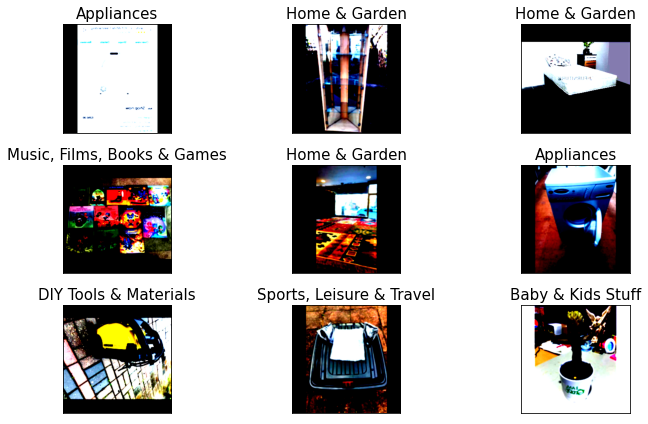

In [ ]:
fig = plt.figure(figsize=(10,6))

for i, example in enumerate(train_dataset):
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0].numpy().transpose((1, 2, 0)))
    # print(image_dataset.idx_to_class[example[1]])
    # ax.set_title(f"{train_dataset.idx_to_class[example[1]]}", size=15)
    ax.set_title(f"{decoder[example[1]]}", size=15)
    if i == 8:
        break

plt.tight_layout()
plt.show()

In [ ]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1))

# Pre-trained ResNet

In [ ]:
USE_GPU = True
dtype = torch.float32 


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')


In [ ]:
device

device(type='cuda', index=0)

### Function to save results amd weights

In [ ]:
def save_weights(model_folder, epoch, model):
  weights_path = model_folder + '/weights'
  if not os.path.exists(weights_path):
    os.mkdir(weights_path)
    print(f' Weights folder created for {model_folder}')
  weight_file_name = f'epoch: {epoch}.pt'
  torch.save(model.state_dict(), weights_path + '/' + weight_file_name)

In [ ]:
def save_epoch_results(file_path, results):
  # Open the CSV file in "append" mode
    with open(file_path, 'a') as f:
      columns=['epoch', 'loss_hist_train', 'accuracy_hist_train', 'loss_hist_valid','accuracy_hist_valid']
      # Create a dictionary writer with the dict keys as column fieldnames
      writer = csv.DictWriter(f, fieldnames=columns)
      # # Append multiple rows to CSV
      writer.writerow(results)


### Define dataloaders

In [ ]:
batch_size=64
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_dl.dataset[0][0].shape

torch.Size([3, 256, 256])

size of the image torch.Size([3, 256, 256])


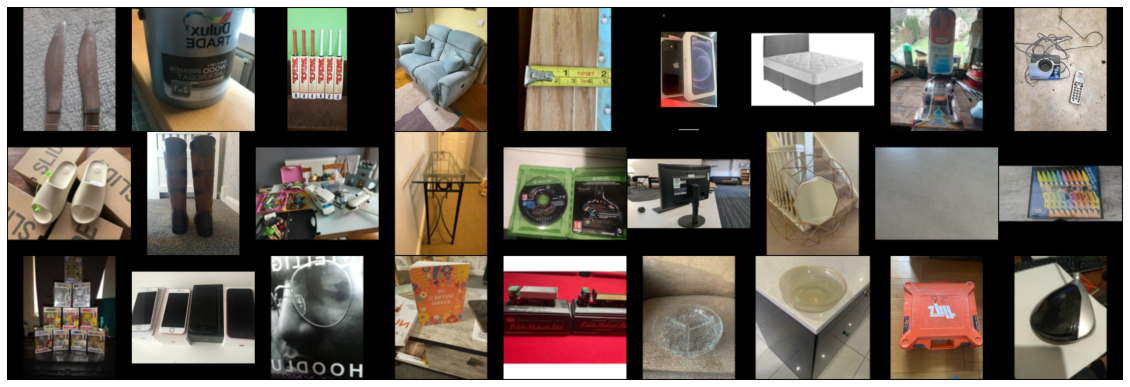

In [ ]:
sample_inputs, _ = next(iter(train_dl))
fixed_input = sample_inputs[:27, :, :, :]
print(f"size of the image {fixed_input[0].shape}")

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

In [ ]:
dataloaders = {'train': train_dl, 'val': valid_dl}

dataset_sizes = {'train': len(train_dl.dataset), 'val': len(valid_dl.dataset)}
dataset_sizes

{'train': 8775, 'val': 1883}

### Training function


In [ ]:
project_directory = "/content/drive/MyDrive/facebook_ranking"

def create_folder(folder_name, dir):
  if not os.path.exists(dir+'/'+folder_name):
    os.mkdir(dir +'/'+folder_name)
def train_model(model, criterion, optimizer, scheduler, num_epochs=5, 
                model_folder_name=None, save_results=False):

    since = time.time()
    if save_results:
      create_folder('final_models', project_directory)
      create_folder('model_evaluation', project_directory)
      create_folder(model_folder_name, project_directory + '/model_evaluation')
      results_path = project_directory + '/model_evaluation/' +\
                     model_folder_name + '/results.csv'

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_hist_train = [0] * num_epochs  
    accuracy_hist_train = [0] * num_epochs 
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            batch_nu = 0
            for inputs, labels in dataloaders[phase]:
                if batch_nu % 10 == 0:
                  print(f"{batch_nu} / {len(dataloaders[phase])}")
                batch_nu += 1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # print(running_loss)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                loss_hist_train[epoch] = epoch_loss
                accuracy_hist_train[epoch] = epoch_acc
            else:
                loss_hist_valid[epoch] = epoch_loss
                accuracy_hist_valid[epoch] = epoch_acc

            if save_results == True and phase == 'val':
              dir = project_directory + '/model_evaluation/' + model_folder_name
              save_weights(dir, epoch, model)
              results = {'epoch': epoch, 'loss_hist_train': round(loss_hist_train[epoch], 4), 
                         'accuracy_hist_train': round(accuracy_hist_train[epoch].cpu().item(), 4), 
                         'loss_hist_valid': round(loss_hist_valid[epoch], 4), 
                         'accuracy_hist_valid': round(accuracy_hist_valid[epoch].cpu().item(),4)}
              
              save_epoch_results(dir + '/results.csv', results)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    hist = [loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid]
    if best_acc >= 0.3:
      torch.save(model.state_dict(), project_directory + '/final_models/' 
                 + model_folder_name+ "_acc:_" + str(round(best_acc.item(),2))+'.pt')

    return model, hist

### Train a pre-trained model - only update weights of last FC layers

In [ ]:
model_ft = models.resnet34(pretrained=True)
# in case we only want to train FC layers
for param in model_ft.parameters():
    param.requires_grad = False

# Adding 2 fully connected layers :  (pre-trained Resnet output features, 1000) & (1000, num_classes)
num_ftrs = model_ft.fc.in_features
print(f"features in FC {num_ftrs}")
model_ft.fc = torch.nn.Linear(num_ftrs, 1000)
# model_ft.add_module('fc2', torch.nn.Linear(1000, len(decoder)))
new_layer = torch.nn.Linear(1000, len(decoder))
model = torch.nn.Sequential(model_ft, new_layer)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


features in FC 512


In [ ]:
model

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
u = model(torch.ones((1,3,252,252)).to(device))
u.shape
# model_ft.fc2(u).shape



Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
model_ft, hist = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=3, model_folder_name='Resnet34_feature_extr_lr_0.001_mom_0.8', save_results=True)

Epoch 0/2
----------
0 / 138
10 / 138
20 / 138
30 / 138
40 / 138
50 / 138
60 / 138
70 / 138
80 / 138
90 / 138
100 / 138
110 / 138
120 / 138
130 / 138
train Loss: 2.3627 Acc: 0.2346
0 / 30
10 / 30
20 / 30
 Weights folder created for /content/drive/MyDrive/facebook_ranking/model_evaluation/Resnet34_feature_extr_lr_0.001_mom_0.8
val Loss: 2.0933 Acc: 0.3707

Epoch 1/2
----------
0 / 138
10 / 138
20 / 138
30 / 138
40 / 138
50 / 138
60 / 138
70 / 138
80 / 138
90 / 138
100 / 138
110 / 138
120 / 138
130 / 138
train Loss: 2.0275 Acc: 0.3827
0 / 30
10 / 30
20 / 30
val Loss: 1.8569 Acc: 0.4365

Epoch 2/2
----------
0 / 138
10 / 138
20 / 138
30 / 138
40 / 138
50 / 138
60 / 138
70 / 138
80 / 138
90 / 138
100 / 138
110 / 138
120 / 138
130 / 138
train Loss: 1.8633 Acc: 0.4294
0 / 30
10 / 30
20 / 30
val Loss: 1.7534 Acc: 0.4498

Training complete in 8m 11s
Best val Acc: 0.449814


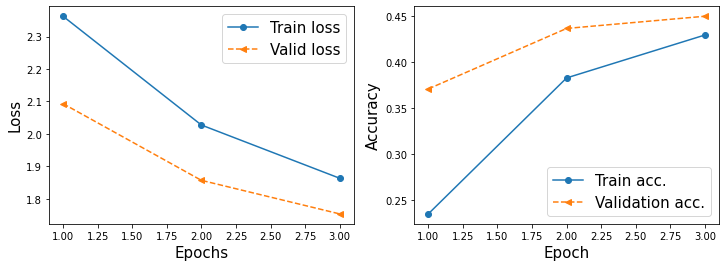

In [ ]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0],  '-o', label='Train loss')
ax.plot(x_arr, hist[2],  '--<', label='Valid loss')
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, [h.cpu() for h in hist[1]], '-o', label='Train acc.')
ax.plot(x_arr, [h.cpu() for h in hist[3]], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

## Fine-tune pre-trained Resnet end-to-end

In [ ]:
model_ft = models.resnet34(pretrained=True)

# Adding 2 fully connected layers :  (pre-trained Resnet output features, 1000) & (1000, num_classes)
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, 1000)
new_layer = torch.nn.Linear(1000, len(decoder))
model = torch.nn.Sequential(model_ft, new_layer)
model = model.to(device)
# model.add_module('fc2', torch.nn.Linear(1000, len(decoder)))


criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
u = model(torch.ones((1,3,252,252)).to(device))
u.shape

torch.Size([1, 13])

In [ ]:
model_ft, hist = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10, model_folder_name='Resnet34_finetune_all_layers_lr_0.001_mom_0.8', save_results=True)

Epoch 0/9
----------
0 / 138
10 / 138
20 / 138
30 / 138
40 / 138
50 / 138
60 / 138
70 / 138
80 / 138
90 / 138
100 / 138
110 / 138
120 / 138
130 / 138
train Loss: 2.2165 Acc: 0.2925
0 / 30
10 / 30
20 / 30
 Weights folder created for /content/drive/MyDrive/facebook_ranking/model_evaluation/Resnet34_finetune_all_layers_lr_0.001_mom_0.8
val Loss: 1.8357 Acc: 0.4418

Epoch 1/9
----------
0 / 138
10 / 138
20 / 138
30 / 138
40 / 138
50 / 138
60 / 138
70 / 138
80 / 138
90 / 138
100 / 138
110 / 138
120 / 138
130 / 138
train Loss: 1.7116 Acc: 0.4596
0 / 30
10 / 30
20 / 30
val Loss: 1.5761 Acc: 0.4971

Epoch 2/9
----------
0 / 138
10 / 138
20 / 138
30 / 138
40 / 138
50 / 138
60 / 138
70 / 138
80 / 138
90 / 138
100 / 138
110 / 138
120 / 138
130 / 138
train Loss: 1.4953 Acc: 0.5192
0 / 30
10 / 30
20 / 30
val Loss: 1.4670 Acc: 0.5226

Epoch 3/9
----------
0 / 138
10 / 138
20 / 138
30 / 138
40 / 138
50 / 138
60 / 138
70 / 138
80 / 138
90 / 138
100 / 138
110 / 138
120 / 138
130 / 138
train Loss: 1.356

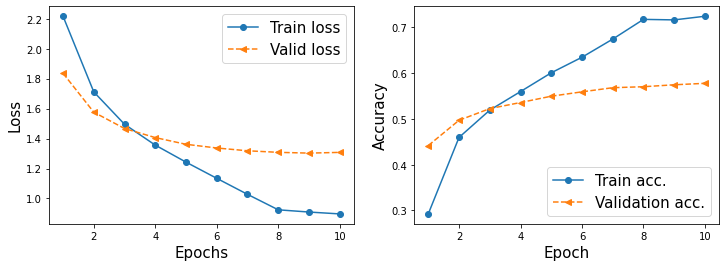

In [ ]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0],  '-o', label='Train loss')
ax.plot(x_arr, hist[2],  '--<', label='Valid loss')
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, [h.cpu() for h in hist[1]], '-o', label='Train acc.')
ax.plot(x_arr, [h.cpu() for h in hist[3]], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

# Test model

In [ ]:
model.eval()
criterion = torch.nn.CrossEntropyLoss()
correctly_classified = 0
with torch.no_grad():
  for i, (x, y) in enumerate(test_dl):
    x = x.to(device)
    y = y.to(device)
    pred = model(x)
    loss = criterion(pred, y)
    # print(pred.argmax(1))
    # print(y)
    # print(pred.argmax(dim=1))
    # print(y == pred.argmax(dim=1))
    is_correct = (pred.argmax(dim=1) == y).sum()
    correctly_classified += is_correct
    
  
  accuracy = correctly_classified / len(test_dl.dataset)
  print(f'{correctly_classified} correctly classified out of {len(test_dl.dataset)}, accuracy: {accuracy}')

1129 correctly classified out of 1882, accuracy: 0.5998937487602234


In [ ]:
pred.shape

torch.Size([26, 13])

# Load model and extract features

In [ ]:
state_dict = torch.load('/content/drive/MyDrive/facebook_ranking/final_models/Resnet34_finetune_all_layers_lr_0.001_mom_0.8_acc:_0.58.pt')
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, 1000)
model = torch.nn.Sequential(model_ft, torch.nn.Linear(1000, len(decoder)))
# model_ft.add_module('fc2', torch.nn.Linear(1000, len(decoder)))

model = model.to(device)
model.load_state_dict(state_dict)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
x = model(train_dataset[0][0].unsqueeze(0).to(device))
x

tensor([[-0.1646,  0.1000, -0.6303, -0.2928, -0.1144,  0.7250,  0.6968, -0.6552,
          0.2361,  0.9621, -0.9991, -0.2201, -0.2426]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
# print(torch.argmax(model_ft.fc2(x), dim=1))
# print(torch.softmax(model_ft.fc2(x), dim=1))
# s, y = model_ft.fc2(x).max(1)
# print(s)
# y

tensor([1], device='cuda:0')
tensor([[0.0337, 0.1746, 0.0591, 0.0205, 0.0362, 0.1666, 0.0587, 0.0437, 0.0794,
         0.0369, 0.1536, 0.0264, 0.1107]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([0.9462], device='cuda:0', grad_fn=<MaxBackward0>)


tensor([1], device='cuda:0')

In [ ]:
# class Identity(torch.nn.Module):
#     def __init__(self):
#         super(Identity, self).__init__()
        
#     def forward(self, x):
#         return x

# model_ft.fc2 = Identity()
# torch.save(model_ft.state_dict(), project_directory + '/final_models/image_model.pt')


In [ ]:
image_model = model[0]
torch.save(model_ft.state_dict(), project_directory + '/final_models/image_model.pt')

# FAISS

In [ ]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

model_fe = models.resnet34(pretrained=True)
num_ftrs = model_fe.fc.in_features
model_fe.fc = torch.nn.Linear(num_ftrs, 1000)
# model_fe.fc2 = Identity()
state_dict = torch.load('/content/drive/MyDrive/facebook_ranking/final_models/image_model.pt')
model_fe.load_state_dict(state_dict)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
def image_processor(image, model):
  
  input_tensor = image.unsqueeze(0)
  return model(input_tensor).detach().squeeze(0).numpy()

In [ ]:
image_embeddings = dict()

for i, (image, label) in enumerate(train_dataset):
  image_id = train_dataset.file_list[i]
  image_embeddings[image_id] = image_processor(image, model_fe)
  print(f"Number {i}, image_id {image_id}")
  if i % 10 == 0:
    print(f"{image_embeddings[image_id].shape} out of {len(train_dataset)}")

Streaming output truncated to the last 5000 lines.
Number 4230, image_id 7ab6b81c-7239-4579-94e8-d826fe49ce6f
(1000,) out of 8775
Number 4231, image_id 7abb3b1c-b21f-4b6a-84db-e079778b16e9
Number 4232, image_id 7ac8250e-a151-4f63-9a17-0207c3baf996
Number 4233, image_id 7ad2bcb7-7396-473f-aa28-d2d009b84369
Number 4234, image_id 7ad95857-bb29-4f9e-889d-e421ba6c9260
Number 4235, image_id 7ae08de1-b746-4b00-b2e4-d45d3af1f5de
Number 4236, image_id 7af7e558-70d4-4d4b-86f5-c25233866dee
Number 4237, image_id 7af91f40-0a8f-4a91-9a61-9708acbae55f
Number 4238, image_id 7af99969-3a54-4466-a019-fdcb69220948
Number 4239, image_id 7afb7ee7-af58-449d-819c-e1c9ac6dd922
Number 4240, image_id 7b054ef2-734d-4ca0-8268-22bf1ee8cc80
(1000,) out of 8775
Number 4241, image_id 7b0bf092-58d3-4d01-bf5f-fe8ad62b512a
Number 4242, image_id 7b1f0e02-c2fa-41e5-aca9-1cd4cb2ebfa7
Number 4243, image_id 7b1f7d20-fd91-4d6e-aeb5-0214e9b0bf4c
Number 4244, image_id 7b214046-4b82-4faf-be41-8146691045ce
Number 4245, image_id 7b

In [ ]:
image_embeddings_dict = {image_id: embedding.tolist() for image_id, embedding in image_embeddings.items()}

In [ ]:
import json
with open(project_directory + '/image_embeddings.json', 'w') as f:
    json.dump(image_embeddings_dict, f)

In [ ]:
index = faiss.IndexFlatL2(1000)

In [ ]:
import json
f = open(project_directory + '/image_embeddings.json')
data = json.load(f)

In [ ]:
embeddings = [np.array(emb) for emb in data.values()]
embeddings = np.array(embeddings)
embeddings = np.float32(embeddings)

In [ ]:
type(embeddings)

numpy.ndarray

In [ ]:
index.add(embeddings) 

In [ ]:
print(index.ntotal)

8775


In [ ]:
xq = np.ones((2,1000))

In [ ]:
xq.shape

(2, 1000)

In [ ]:
k = 4                          # we want 4 similar vectors
D, I = index.search(np.float32(xq), k)     # actual search
print(I)

[[1327 3505 2663 8556]
 [1327 3505 2663 8556]]


In [ ]:
type(data)
len(data['fecdcbbc-ded5-468d-94ef-0cc047f8861c'])

1000

In [ ]:
image_processor(train_dataset[0][0], model_fe).detach().squeeze(0).numpy().shape

AttributeError: ignored

#Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def confusion(preds, y):
  labels = train_dataset.classes
  # Plotting the confusion matrix
  cm = confusion_matrix(y.cpu().numpy(), preds.cpu().numpy(), normalize='true')
  fig, ax= plt.subplots(1, 1, figsize=(15,10))
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(labels, rotation = 70); ax.yaxis.set_ticklabels(labels, rotation=0);
  plt.show()

def incorrect_preds(preds, y, test_img):
  labels = train_dataset.classes
  # lets see a sample of the images which were classified incorrectly!
  correct = (preds == y).float()
  test_labels_check = correct.cpu().numpy()
  incorrect_indexes = np.where(test_labels_check == 0)

  test_img = test_img.cpu()
  samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                      padding=2, normalize=False, value_range=None, 
                      scale_each=False, pad_value=0)
  plt.figure(figsize = (20,10))
  plt.title('Incorrectly Classified Instances')
  show(samples)
  labels = np.asarray(labels)
  print('Predicted label',labels[preds[incorrect_indexes].cpu().numpy()[:9]])
  print('True label', labels[y[incorrect_indexes].cpu().numpy()[:9]])
  print('Corresponding images are shown below')

In [ ]:
print_every = 10
def check_accuracy(loader, model, analysis=False):
    # function for test accuracy on validation and test set
    
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            if t == 0 and analysis:
              stack_labels = y
              stack_predicts = preds
            elif analysis:
              stack_labels = torch.cat([stack_labels, y], 0)
              stack_predicts = torch.cat([stack_predicts, preds], 0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct of val set (%.2f)' % (num_correct, num_samples, 100 * acc))
        if analysis:
          print('check acc', type(stack_predicts), type(stack_labels))
          confusion(stack_predicts, stack_labels)
          incorrect_preds(preds, y, x)
        return float(acc)

Got 1087 / 1883 correct of val set (57.73)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


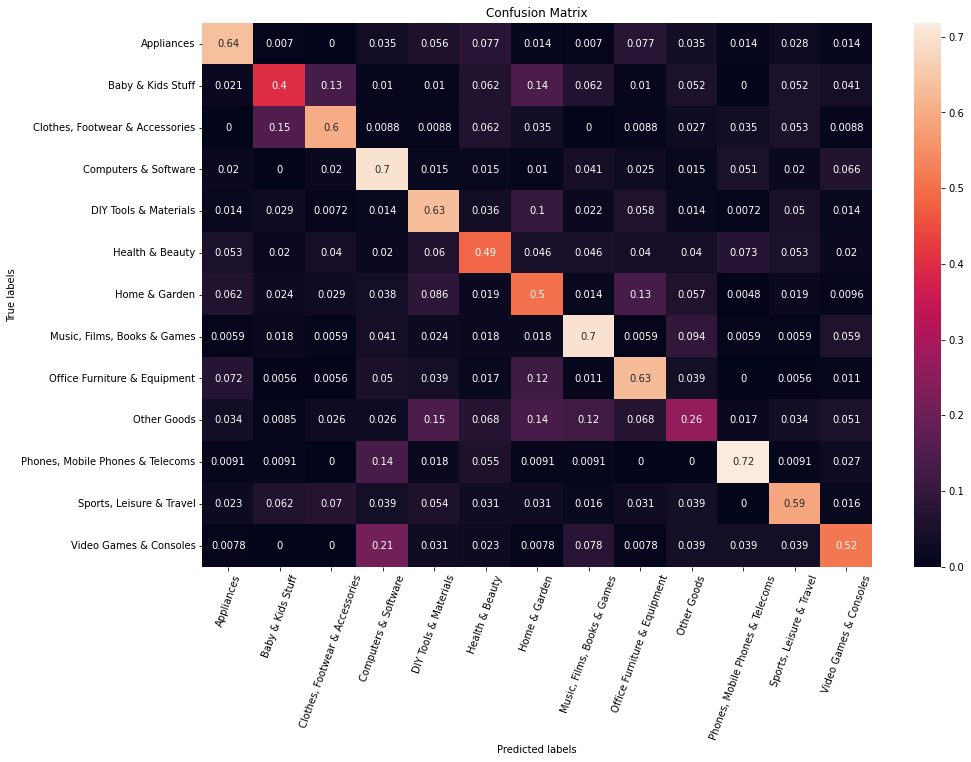

Predicted label ['Home & Garden' 'Video Games & Consoles' 'Office Furniture & Equipment'
 'Computers & Software' 'Other Goods' 'Other Goods' 'Appliances'
 'Appliances' 'Video Games & Consoles']
True label ['Office Furniture & Equipment' 'Baby & Kids Stuff' 'Home & Garden'
 'Video Games & Consoles' 'Video Games & Consoles' 'Home & Garden'
 'Sports, Leisure & Travel' 'Office Furniture & Equipment'
 'Music, Films, Books & Games']
Corresponding images are shown below


0.5772703133297928

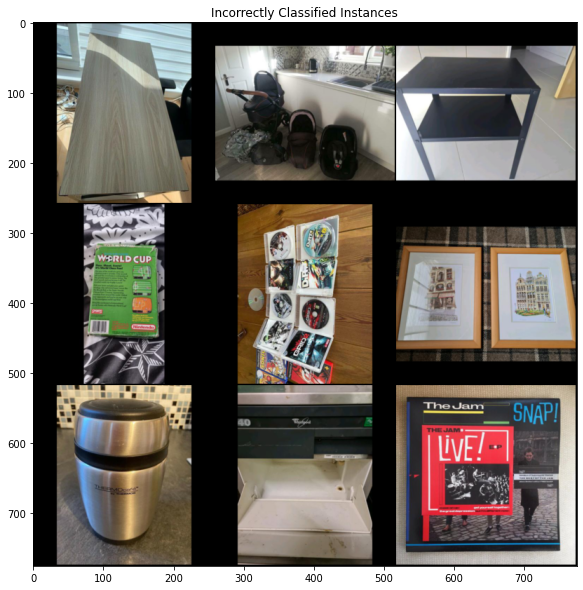

In [ ]:
check_accuracy(valid_dl, model_ft, analysis=True)

Got 1097 / 1882 correct of val set (58.29)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


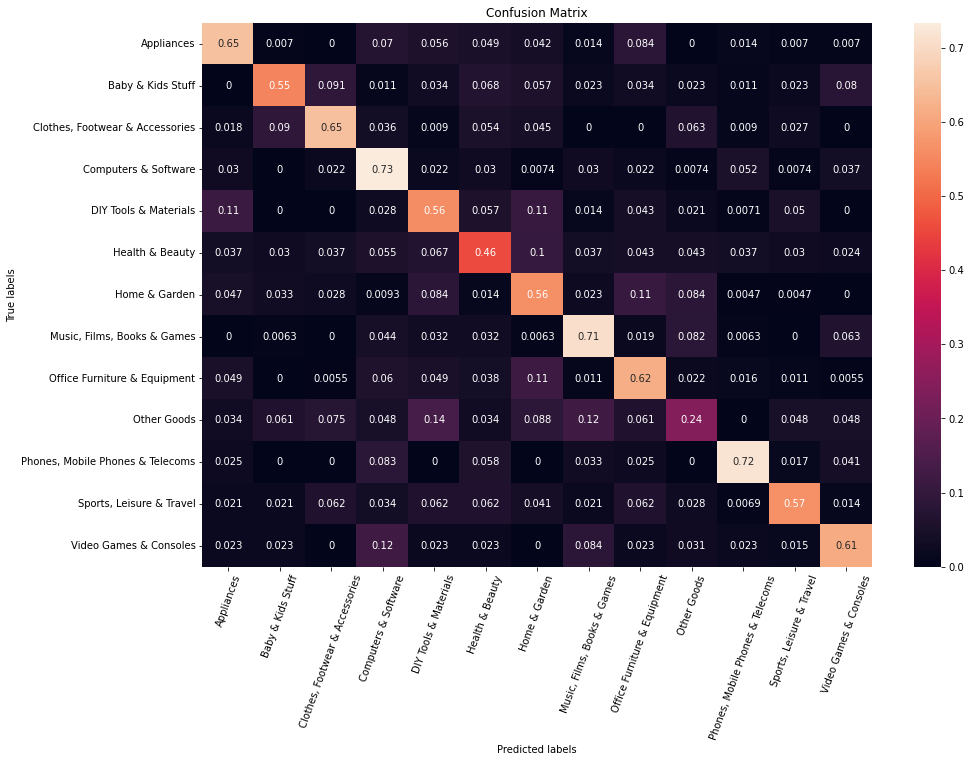

Predicted label ['Health & Beauty' 'Music, Films, Books & Games' 'Appliances'
 'Computers & Software' 'Home & Garden' 'Other Goods'
 'Computers & Software' 'Other Goods' 'Health & Beauty']
True label ['Appliances' 'Health & Beauty' 'Clothes, Footwear & Accessories'
 'Office Furniture & Equipment' 'Appliances' 'DIY Tools & Materials'
 'Other Goods' 'Home & Garden' 'Clothes, Footwear & Accessories']
Corresponding images are shown below


0.5828905419766206

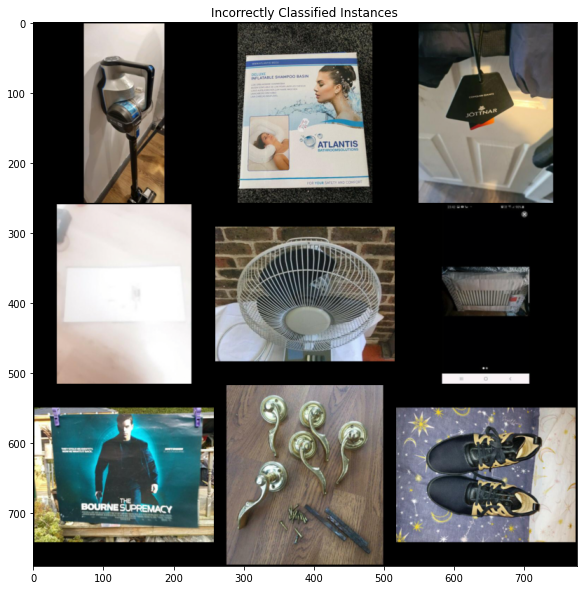

In [ ]:
check_accuracy(test_dl, model_ft, analysis=True)

# Building Resnet

In [ ]:
class ResidualBlock(torch.nn.Module):
  def __init__(self, inchannel, outchannel, stride):
    super(ResidualBlock, self).__init__() 
    self.left = torch.nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                    stride=stride, padding=1, bias=False), 
                                    torch.nn.BatchNorm2d(outchannel), 
                                    torch.nn.ReLU(inplace=True), 
                                    Conv2d(outchannel, outchannel, kernel_size=3, 
                                            stride=1, padding=1, bias=False), 
                                    torch.nn.BatchNorm2d(outchannel)) 
    self.shortcut = torch.nn.Sequential()

    if stride != 1 or outchannel!= inchannel:
      self.shortcut = torch.nn.Sequential(Conv2d(in_channels=inchannel, out_channels=outchannel,
                                                 kernel_size=1, stride=stride, padding=0, bias=False),
                                          torch.nn.BatchNorm2d(outchannel))
  
  def forward(self, x):
    out = self.left(x)
    out += self.shortcut(x)
    out = torch.nn.functional.relu(out)
    return out


In [ ]:
class ResNet(torch.nn.Module):
  def __init__(self, ResidualBlock, num_classes=13):
    super(ResNet, self).__init__()
    self.conv1 = torch.nn.Sequential(Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
                                     torch.nn.BatchNorm2d(16),
                                     torch.nn.ReLU())
    # size = 16, 512, 512
    self.inchannel = 16
    self.layer1 = self.make_layer(ResidualBlock, channels=16, num_blocks=2, stride=2)
    # size = 16, 256, 256
    self.layer2 = self.make_layer(ResidualBlock, channels=32, num_blocks=2, stride=2)
    # size = 32, 128, 128
    self.layer3 = self.make_layer(ResidualBlock, channels=64, num_blocks=3, stride=2)
    # size = 64, 64, 64
    self.layer4 = self.make_layer(ResidualBlock, channels=128, num_blocks=4, stride=2)
    # size = 128, 32, 32
    self.layer5 = self.make_layer(ResidualBlock, channels=256, num_blocks=6, stride=2)
    # size = 256, 16, 16
    self.layer6 = self.make_layer(ResidualBlock, channels=512, num_blocks=3, stride=2)
    # size = 512, 8, 8
    self.max_pool = MaxPool2d(kernel_size=4)
    self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
    self.fc = torch.nn.Linear(512, num_classes)

  def make_layer(self, block, channels, num_blocks, stride):
      
      strides = [stride] + [1] * (num_blocks - 1)
      
      layers = []
      
      for stride in strides:
          
          layers.append(block(self.inchannel, channels, stride))
          
          self.inchannel = channels
      
          
      return torch.nn.Sequential(*layers)
  
  def forward(self, x):
      # print(x.shape)
      x = self.conv1(x)
      # print(x.shape)
      
      x = self.layer1(x)
      # print(x.shape)
      x = self.layer2(x)
      # print(x.shape)
      x = self.layer3(x)
      # print(x.shape)
      x = self.layer4(x)
      # print(x.shape)
      x = self.layer5(x)
      # print(x.shape)
      x = self.layer6(x)
      # print(x.shape)
      # x = self.max_pool(x)
      x = self.avgpool(x)
      x = x.view(x.size(0), -1)
      # x = F.dropout(x, p=0.5)
      # x = F.relu(self.fc(x))
      # # x = F.dropout(x, p=0.2)
      # x = self.fc2(x)
      x = self.fc(x)
      
      return x
  
def MyResNet():
  return ResNet(ResidualBlock)

In [ ]:
#%%
model = MyResNet()
# checking that the output is of a shape (batch_size, 13)
dummy = torch.ones(size=(4,3,256,256))
model(dummy).argmax(dim=1)




tensor([5, 5, 5, 5])

In [ ]:
from torchsummary import summary
summary(model, (3, 512, 512))

RuntimeError: ignored

In [ ]:
len(train_dl)

138

In [ ]:
optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()
batch_size = 64

NameError: ignored

### Train function

In [ ]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs  
    accuracy_hist_train = [0] * num_epochs 
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            optimiser.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)

            loss.backward()
            optimiser.step()
            # print(loss.item())
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1).float() == y_batch).float()
            # print(torch.argmax(pred, dim=1))
            # print (y_batch, is_correct)
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
          for x_batch, y_batch in valid_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1).float() == y_batch).float()
            accuracy_hist_valid[epoch] += is_correct.sum()
          
          accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
          loss_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} train loss: ',
            f'{loss_hist_train[epoch]:.4f}  valuation loss: {loss_hist_valid[epoch]:.4f}') 
        print(f'Epoch {epoch+1} train accuracy: ',
            f'{accuracy_hist_train[epoch]:.4f}  valuation accuracy: {accuracy_hist_valid[epoch]:.4f}')
    
    return loss_hist_train, loss_hist_valid, \
          accuracy_hist_train, accuracy_hist_valid


In [ ]:
hist = train(model, 12, train_dl, valid_dl)

Epoch 1 train loss:  2.5284  valuation loss: 2.4877
Epoch 1 train accuracy:  0.1298  valuation accuracy: 0.1541
Epoch 2 train loss:  2.4236  valuation loss: 2.4459
Epoch 2 train accuracy:  0.1768  valuation accuracy: 0.1738
Epoch 3 train loss:  2.3376  valuation loss: 2.4842
Epoch 3 train accuracy:  0.2134  valuation accuracy: 0.1738
Epoch 4 train loss:  2.2622  valuation loss: 2.4622
Epoch 4 train accuracy:  0.2452  valuation accuracy: 0.1791
Epoch 5 train loss:  2.1622  valuation loss: 2.4392
Epoch 5 train accuracy:  0.2884  valuation accuracy: 0.2056
Epoch 6 train loss:  2.0768  valuation loss: 2.3817
Epoch 6 train accuracy:  0.3102  valuation accuracy: 0.2311
Epoch 7 train loss:  1.9806  valuation loss: 2.4080
Epoch 7 train accuracy:  0.3513  valuation accuracy: 0.2226
Epoch 8 train loss:  1.8496  valuation loss: 2.3880
Epoch 8 train accuracy:  0.3987  valuation accuracy: 0.2471
Epoch 9 train loss:  1.7492  valuation loss: 2.5829
Epoch 9 train accuracy:  0.4208  valuation accuracy:

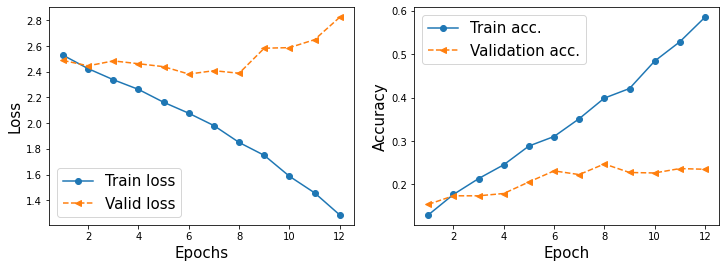

In [ ]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0],  '-o', label='Train loss')
ax.plot(x_arr, hist[1],  '--<', label='Valid loss')
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, [h.cpu() for h in hist[2]], '-o', label='Train acc.')
ax.plot(x_arr, [h.cpu() for h in hist[3]], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [ ]:
import csv
hist_to_save = list(hist).copy()
hist_to_save[0] = hist[0]
hist_to_save[1] = hist[1]
hist_to_save[2] = [h.cpu().item() for h in hist[2]]
hist_to_save[3] = [h.cpu().item() for h in hist[3]]
with open("/content/drive/MyDrive/facebook_ranking/outRes34lr=0.0001.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(hist_to_save)

In [ ]:
check_accuracy(valid_dl, model, analysis=True)

NameError: ignored

### Test model loads

In [ ]:
def image_processor(image, model):
  
  input_tensor = transform_train(image).unsqueeze(1)
  model(input_tensor)



In [ ]:
print("Model's state_dict:")
for param_tensor in model_ft.state_dict():
    print(param_tensor, "\t", model_ft.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([64, 3, 7, 7])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.1.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight 	 torch.Size([64])
layer1.1.bn1.bias 	 torch.Size([64])
layer1.1.bn1.running_mean 	 torch.Size([64])
layer1.1.bn1.running_var 	 torch.Size([64])
layer1.1.bn1.num_batc

# Appendix: CNN Model

In [ ]:
class CNNModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #initial image = (3, 512, 512)
        self.conv1 = torch.nn.Sequential(
                     torch.nn.Conv2d(3, 32, kernel_size=3, padding=2),
                     torch.nn.ReLU(),
                     torch.nn.MaxPool2d(kernel_size=2),
                     torch.nn.Dropout(p=0.5)
        )
        #image = (32, 256, 256)
        self.conv2 = torch.nn.Sequential(
                     torch.nn.Conv2d(32, 64, kernel_size=3, padding=2),
                     torch.nn.ReLU(),
                     torch.nn.MaxPool2d(kernel_size=2),
                     torch.nn.Dropout(p=0.5)
        )
        #image = (64, 128, 128)
        self.conv3 = torch.nn.Sequential(
                     torch.nn.Conv2d(64, 128, kernel_size=3, padding=2),
                     torch.nn.ReLU(),
                     torch.nn.MaxPool2d(kernel_size=2),
                     torch.nn.Dropout(p=0.5)
        )
        #image = (128, 64, 64)
        self.conv4 = torch.nn.Sequential(
                     torch.nn.Conv2d(128, 256, kernel_size=3, padding=2),
                     torch.nn.ReLU(),
                     torch.nn.MaxPool2d(kernel_size=2),
                     torch.nn.Dropout(p=0.5)
        )
        #image = (256, 32, 32)
        self.conv5 = torch.nn.Sequential(
                     torch.nn.Conv2d(256, 512, kernel_size=3, padding=2),
                     torch.nn.ReLU(),
                     torch.nn.MaxPool2d(kernel_size=2),
                     torch.nn.Dropout(p=0.5)
        )
        #image = (512, 16, 16)
        self.av_pool = torch.nn.AvgPool2d(kernel_size=16)
        # image = (512, 1, 1)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(512, 13)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.av_pool(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

#%%
model = CNNModel()
# checking that the output is of a shape (batch_size, 13)
dummy = torch.ones(size=(4,3,512,512))
print(model(dummy).shape)
# model
#%%
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCELoss()
batch_size = 32
train_dl = DataLoader(image_dataset, batch_size=batch_size, shuffle=True)
#%%
def train(model, num_epochs, train_dl):
    loss_train_hist = [0] * num_epochs  
    acc_train_hist = [0] * num_epochs 

    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            optimiser.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)

            loss.backward()
            optimiser.step()

            loss_train_hist[epoch] = loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred).float() == y_batch).float()
            acc_train_hist[epoch] += is_correct.sum()

        loss_train_hist[epoch] /= len(train_dl.dataset)
        acc_train_hist[epoch] /= len(train_dl.dataset)
    
    return loss_train_hist, acc_train_hist

# %%
train(model, 1, train_dl)
# %%
